In [14]:
import cv2, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from skimage.exposure import rescale_intensity
from skimage.morphology import disk, square, erosion, dilation, area_closing, remove_small_objects, opening, closing
from skimage.util import invert

# Initialization / Loading data

In [15]:
# Path containing testing / training data
test_path = '../Data/'
train_path = '../Data/TRAIN/'

In [16]:
def read_csv_or_none(csv_path):
    try:
        return pd.read_csv(csv_path, header=None)
    except:
        return None

In [17]:
def plot_img(img, gt=None, title='', cmap='gray', scatter=30):
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    
    if gt is not None:
        xs = list(gt[0])
        ys = list(gt[1])
        for idx in range(len(xs)):
            j, i = ys[idx], xs[idx]
            plt.scatter(j, i, color='r', s=scatter)

## Testing data

In [18]:
# Init testing data
test_img_list = []
test_csv_list = []
test_title_list = []

for file in glob.glob(test_path + '*.jpg'):
    test_img_list.append(cv2.imread(file))
    test_csv_list.append(read_csv_or_none(file[:-3] + 'csv'))
    test_title_list.append(file[:-4])
    
test_nb_images = len(test_img_list)
print('Testing dataset contains {} images'.format(test_nb_images))

Testing dataset contains 5 images


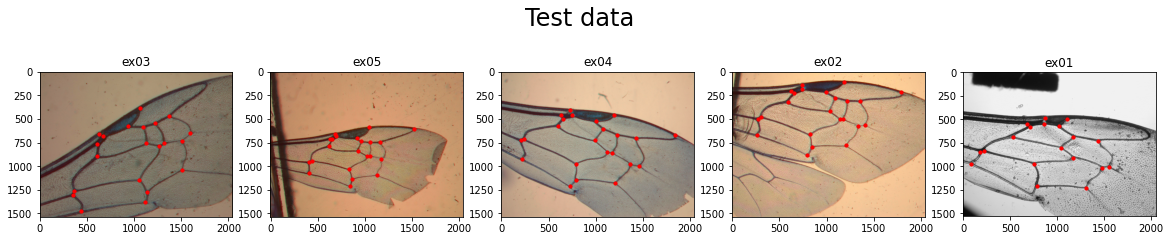

In [19]:
# Display images

plt.figure(figsize=(20, 4))
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    
    plt.subplot(1, test_nb_images, i + 1)
    plot_img(test_img_list[i], test_csv_list[i], title, scatter=10)
    
plt.suptitle('Test data', fontsize=24)
plt.show()

## Training data

In [20]:
# Init training data
train_img_list = []
train_csv_list = []
train_title_list = []

for file in glob.glob(train_path + '*.jpg'):
    train_img_list.append(cv2.imread(file))
    train_csv_list.append(read_csv_or_none(file[:-3] + 'csv'))
    train_title_list.append(file[:-4])
    

train_nb_images = len(train_img_list)
print('Training dataset contains {} images'.format(train_nb_images))

Training dataset contains 32 images


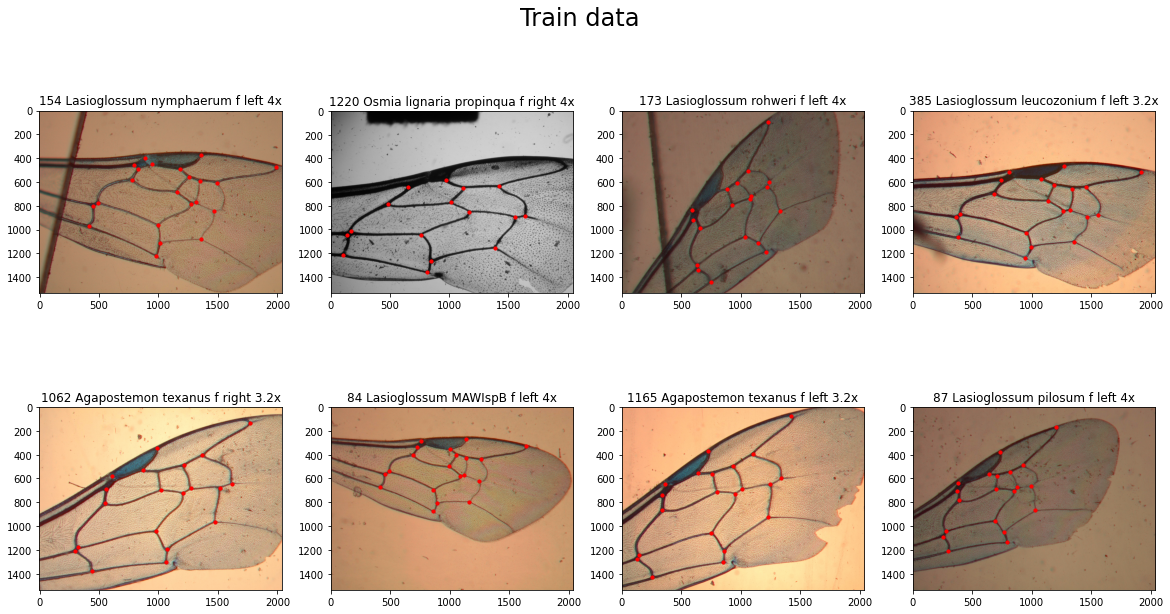

In [21]:
# Display first 8 images

plt.figure(figsize=(20, 10))
for i in range(8):
    title = train_title_list[i].split('/')[-1]
    
    plt.subplot(2, 4, i + 1)
    plot_img(train_img_list[i], train_csv_list[i], title, scatter=10)
    
plt.suptitle('Train data', fontsize=24)
plt.show()

# Image preprocessing

### 1 - Grayscale

In [22]:
def RGB_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### 2 - Rescale intensity

In [23]:
def apply_intensity_rescale(img):
    p1, p2 = np.percentile(img, (10, 95))
    return rescale_intensity(img, in_range=(p1, p2))

### 3 - Threshold

In [24]:
def apply_threshold(img, threshold_value):
    _, img = cv2.threshold(img, threshold_value, 255, 0)
    return img

### 4 - Remove small objects

In [25]:
def remove_small_obj(img, min_size):
    tmp = (invert(img) > 0).copy()
    tmp = remove_small_objects(tmp, min_size=min_size)
    return invert(tmp)

### 5 - Opening

In [26]:
def apply_opening(img, footprint):
    return opening(img, footprint)

### 6 - Closing

In [27]:
def apply_closing(img, footprint):
    return closing(img, footprint)

### 7 - Connected Components

In [28]:
def compute_connected_components(img):
    return cv2.connectedComponents(img.astype(np.uint8))[1]

### Preprocessing pipeline

In [29]:
def print_string_if_true(condition, string):
    if condition:
        print(string)

def apply_preprocessing(img, display=False, verbose=False):
    img_list = [img]
    
    print_string_if_true(verbose, "1 - RGB to gray")
    img_list.append(RGB_to_gray(img_list[-1]))
    
    print_string_if_true(verbose, "2 - Intensity rescale")
    img_list.append(apply_intensity_rescale(img_list[-1]))
    
    print_string_if_true(verbose, "3 - Threshold")
    img_list.append(apply_threshold(img_list[-1], 100))
    
    print_string_if_true(verbose, "4 - Remove small objects")
    img_list.append(remove_small_obj(img_list[-1], 300))
    
    print_string_if_true(verbose, "5 - Opening")
    img_list.append(apply_opening(img_list[-1], disk(5)))
    
    print_string_if_true(verbose, "6 - Closing")
    img_list.append(apply_closing(img_list[-1], square(2)))
    
    print_string_if_true(verbose, "7 - Connected components")
    img_list.append(compute_connected_components(img_list[-1]))
    
    if display:
        plt.figure(figsize=(20, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(img_list[0])
        plt.title('Original image')

        for i in range(1, 7):
            plt.subplot(2, 4, i + 1)
            plt.imshow(img_list[i], cmap='gray')
            plt.title('Step {}'.format(i))
        
        plt.subplot(2, 4, 8)
        plt.imshow(img_list[-1], cmap='turbo')
        plt.title('Step 7')

        plt.show()
    
    return img_list[-1]

**FIXME : Preprocessing does not work well for train_img_list[-5]**

1 - RGB to gray
2 - Intensity rescale
3 - Threshold
4 - Remove small objects
5 - Opening
6 - Closing
7 - Connected components


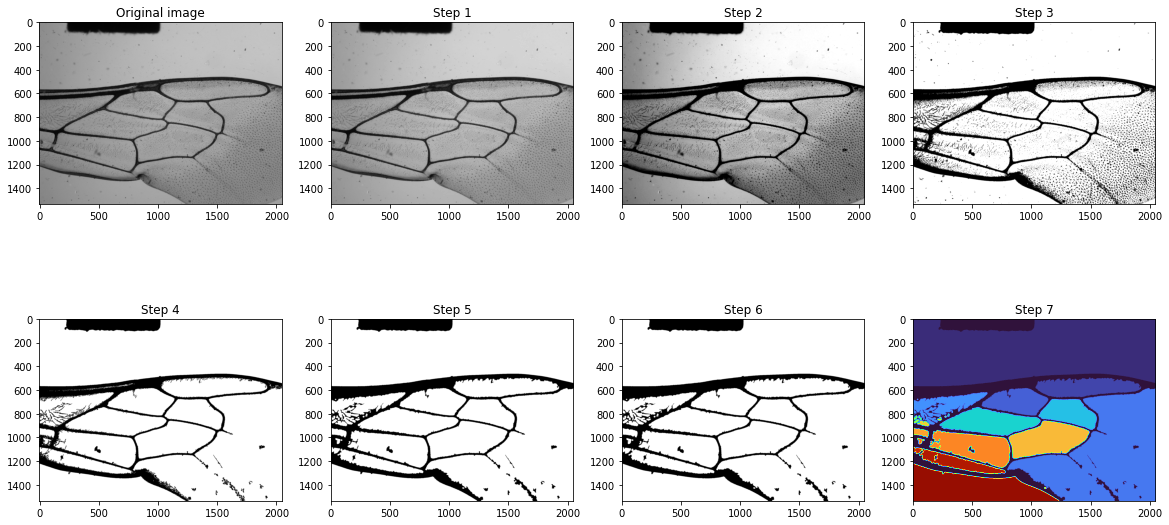

In [30]:
# Apply preprocessing for a random image of one of the datasets
_ = apply_preprocessing(train_img_list[-5], display=True, verbose=True)

## Testing data

In [31]:
test_preprocessed_img_list = []

for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    print('Apply preprocessing on {}'.format(title))
    
    preprocessed_img = apply_preprocessing(test_img_list[i])
    test_preprocessed_img_list.append(preprocessed_img)

Apply preprocessing on ex03
Apply preprocessing on ex05
Apply preprocessing on ex04
Apply preprocessing on ex02
Apply preprocessing on ex01


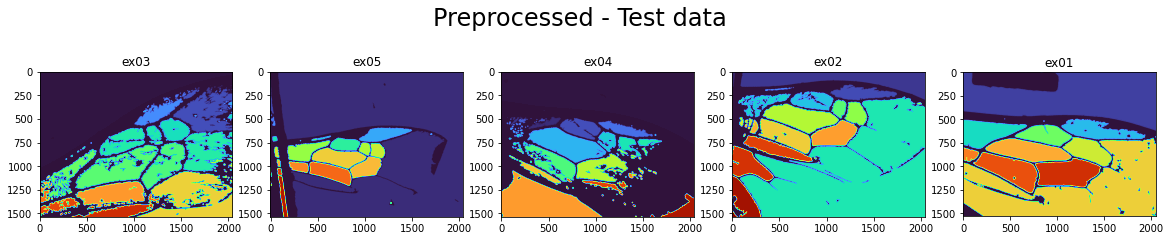

In [32]:
# Display images

plt.figure(figsize=(20, 4))
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    
    plt.subplot(1, test_nb_images, i + 1)
    plt.imshow(test_preprocessed_img_list[i], cmap='turbo')
    plt.title(title)
    
plt.suptitle('Preprocessed - Test data', fontsize=24)
plt.show()

## Training data

In [33]:
train_preprocessed_img_list = []

for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    print('Apply preprocessing on {}'.format(title))
    
    preprocessed_img = apply_preprocessing(train_img_list[i])
    train_preprocessed_img_list.append(preprocessed_img)

Apply preprocessing on 154 Lasioglossum nymphaerum f left 4x
Apply preprocessing on 1220 Osmia lignaria propinqua f right 4x
Apply preprocessing on 173 Lasioglossum rohweri f left 4x
Apply preprocessing on 385 Lasioglossum leucozonium f left 3.2x
Apply preprocessing on 1062 Agapostemon texanus f right 3.2x
Apply preprocessing on 84 Lasioglossum MAWIspB f left 4x
Apply preprocessing on 1165 Agapostemon texanus f left 3.2x
Apply preprocessing on 87 Lasioglossum pilosum f left 4x
Apply preprocessing on 1118 Osmia lignaria lignaria f right 4x
Apply preprocessing on 50 Lasioglossum rohweri f right 4x
Apply preprocessing on 7 Lasioglossum leucozonium f left 3.2x
Apply preprocessing on 154 Lasioglossum nymphaerum f right 4x
Apply preprocessing on 85 Lasioglossum rohweri f right 4x
Apply preprocessing on 133 Lasioglossum nymphaerum f right 4x
Apply preprocessing on 133 Lasioglossum nymphaerum f left 4x
Apply preprocessing on 004 Osmia lignaria f right 4x
Apply preprocessing on 013 Osmia texana

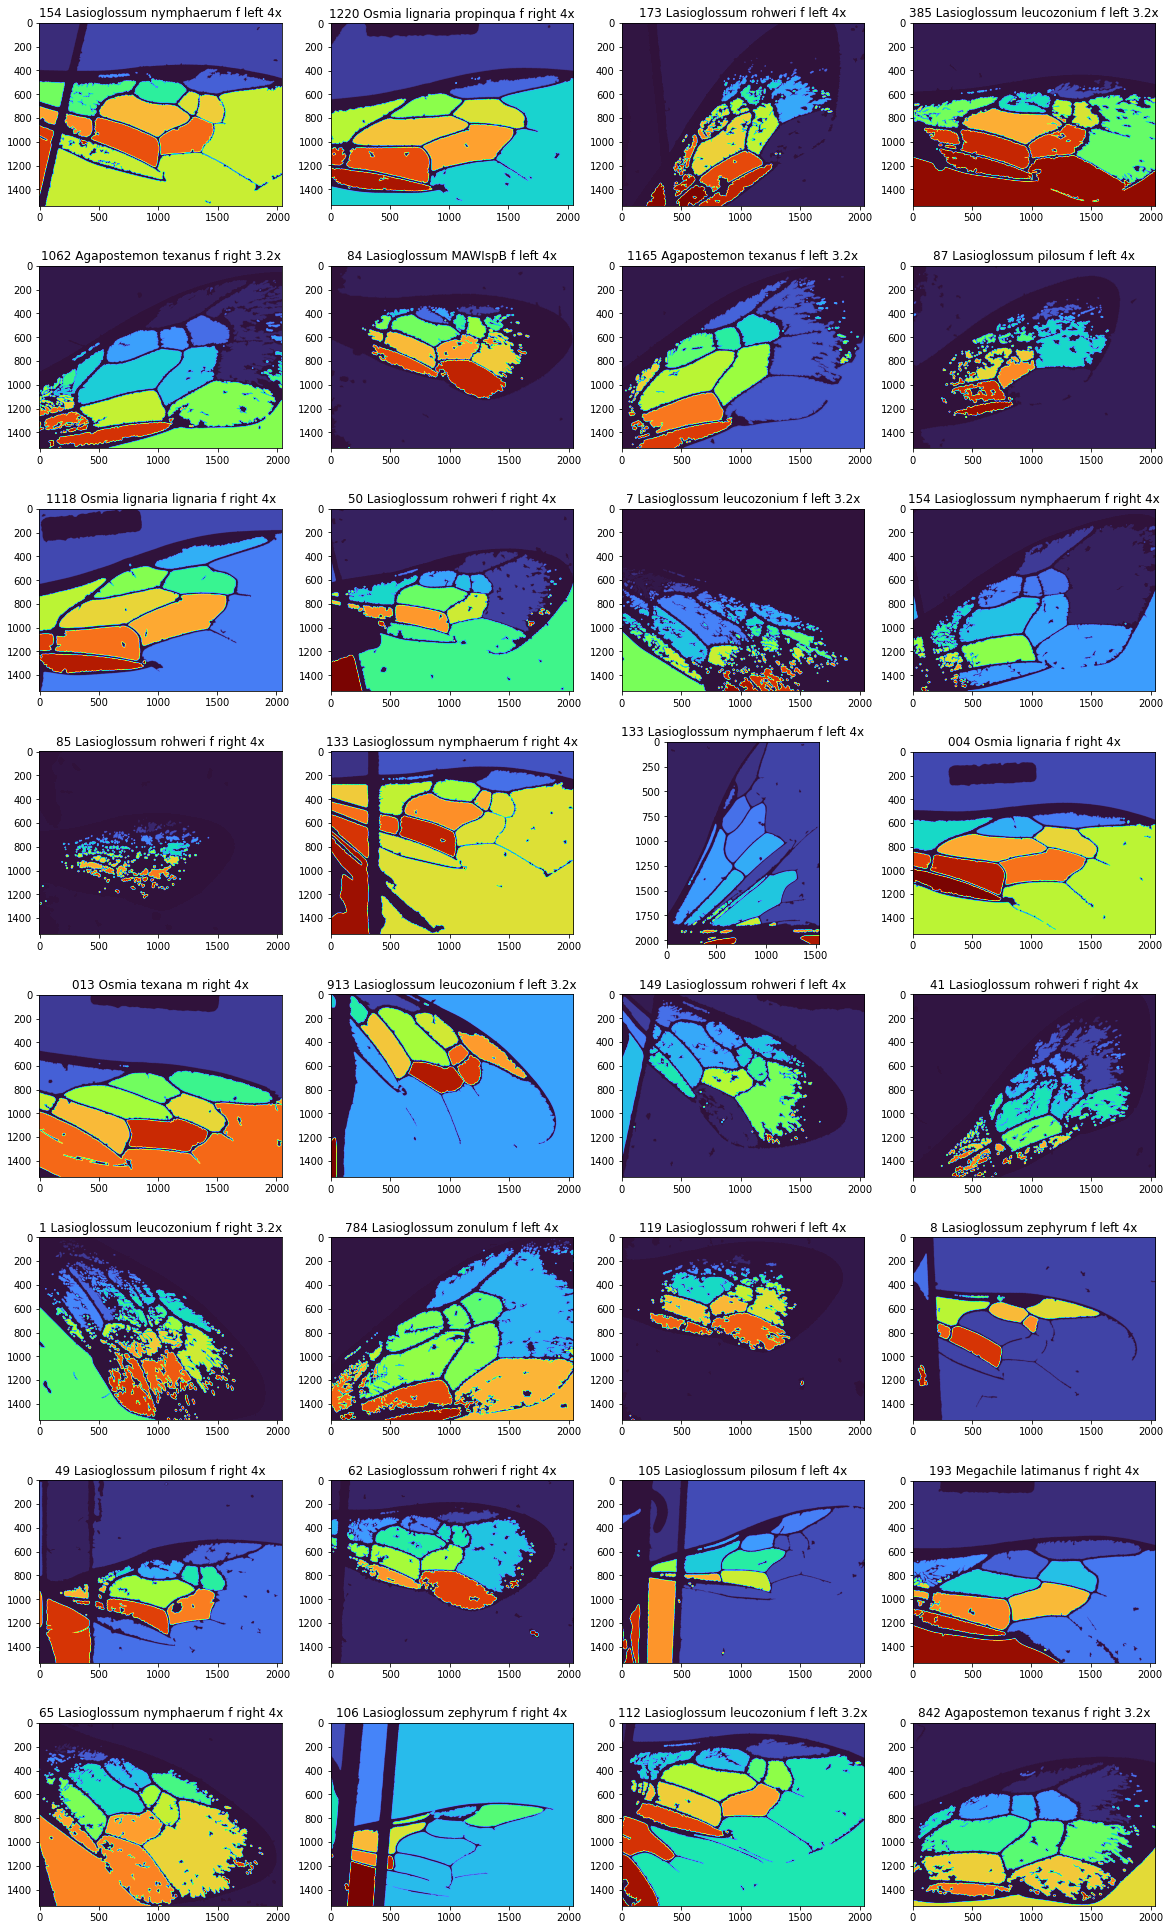

In [34]:
# Display 4 images per line

plt.figure(figsize=(20, 35))
for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    
    plt.subplot(8, 4, i + 1)
    plt.imshow(train_preprocessed_img_list[i], cmap='turbo')
    plt.title(title)
    
plt.show()

# Intersections detection

In [35]:
def detect_intersection(img, window_size, min_count=20):
    shape = img.shape    
    h_window_size = window_size // 2
    intersections = pd.DataFrame(columns=[0, 1])
    
    for i in range(0, shape[0] - window_size, h_window_size):
        for j in range(0, shape[1] - window_size, h_window_size):
            img_window = img[i:i+window_size, j:j+window_size]
            
            _, count = np.unique(img_window, return_counts=True)
            # Check if img_window contains at least 3 colors and each component contains more than min_count points
            if len(count[count > min_count]) > 3:
                intersections.loc[intersections.shape[0]] = [i + h_window_size, j + h_window_size]
            
    return intersections

In [36]:
def build_intersections_image(img, intersections):
    img_zeros = np.zeros_like(img)
    for [x, y] in intersections.values.tolist():
        img_zeros[x, y] = 1
    return img_zeros

In [37]:
def merge_intersection_points(img, intersections, window_size, start_idx=0):
    shape = img.shape
    h_window_size = window_size // 2
    new_intersections = pd.DataFrame(columns=[0, 1])
    
    img_zeros = build_intersections_image(img, intersections)
    
    for i in range(start_idx, shape[0] - window_size, window_size):
        for j in range(start_idx, shape[1] - window_size, window_size):
            img_window = img_zeros[i:i+window_size, j:j+window_size]
            
            components, _ = np.unique(img_window, return_counts=True)
            # Check if img_window contains 0 and 1
            if len(components) == 2:
                indices = np.argwhere(img_window == 1)
                mean_x = int(np.mean(indices[:, 0]))
                mean_y = int(np.mean(indices[:, 1]))
                
                new_intersections.loc[new_intersections.shape[0]] = [i + mean_x, j + mean_y]
    
    return new_intersections

### TODO: remove it - Test

In [38]:
img = test_preprocessed_img_list[1]
img_ref = test_img_list[1]
csv_ref = test_csv_list[1]
intersections = detect_intersection(img, 80)

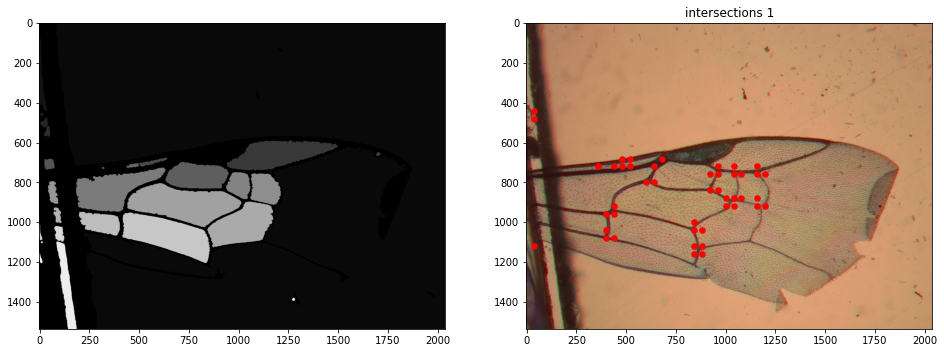

In [39]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plot_img(img)

plt.subplot(1, 2, 2)
plot_img(img_ref, intersections)
plt.title('intersections 1')
plt.show()

In [40]:
new_intersections = merge_intersection_points(img, intersections, 100)

In [41]:
new_intersections2 = merge_intersection_points(img, new_intersections, 80, start_idx=40)

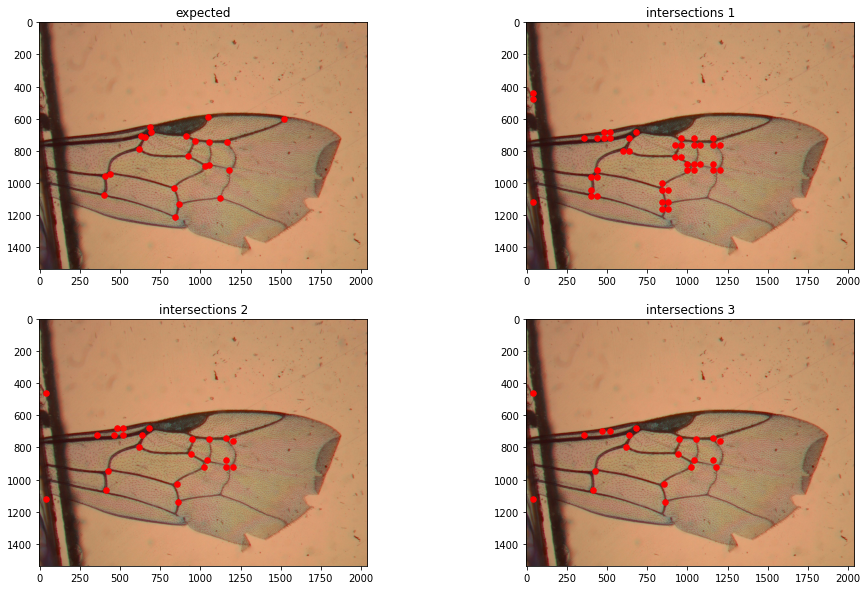

In [42]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plot_img(img_ref, csv_ref)
plt.title('expected')

plt.subplot(2, 2, 2)
plot_img(img_ref, intersections)
plt.title('intersections 1')

plt.subplot(2, 2, 3)
plot_img(img_ref, new_intersections)
plt.title('intersections 2')

plt.subplot(2, 2, 4)
plot_img(img_ref, new_intersections2)
plt.title('intersections 3')
plt.show()

## Intersection detection on test data

In [43]:
test_intersection_list = []
window_size = 70

for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    print('Intersection detection on {}'.format(title))
    
    intersection = detect_intersection(test_preprocessed_img_list[i], window_size)
    intersection = merge_intersection_points(test_preprocessed_img_list[i], intersection, 100)
    intersection = merge_intersection_points(test_preprocessed_img_list[i], intersection, 80, start_idx=40)
    
    test_intersection_list.append(intersection)

Intersection detection on ex03
Intersection detection on ex05
Intersection detection on ex04
Intersection detection on ex02
Intersection detection on ex01


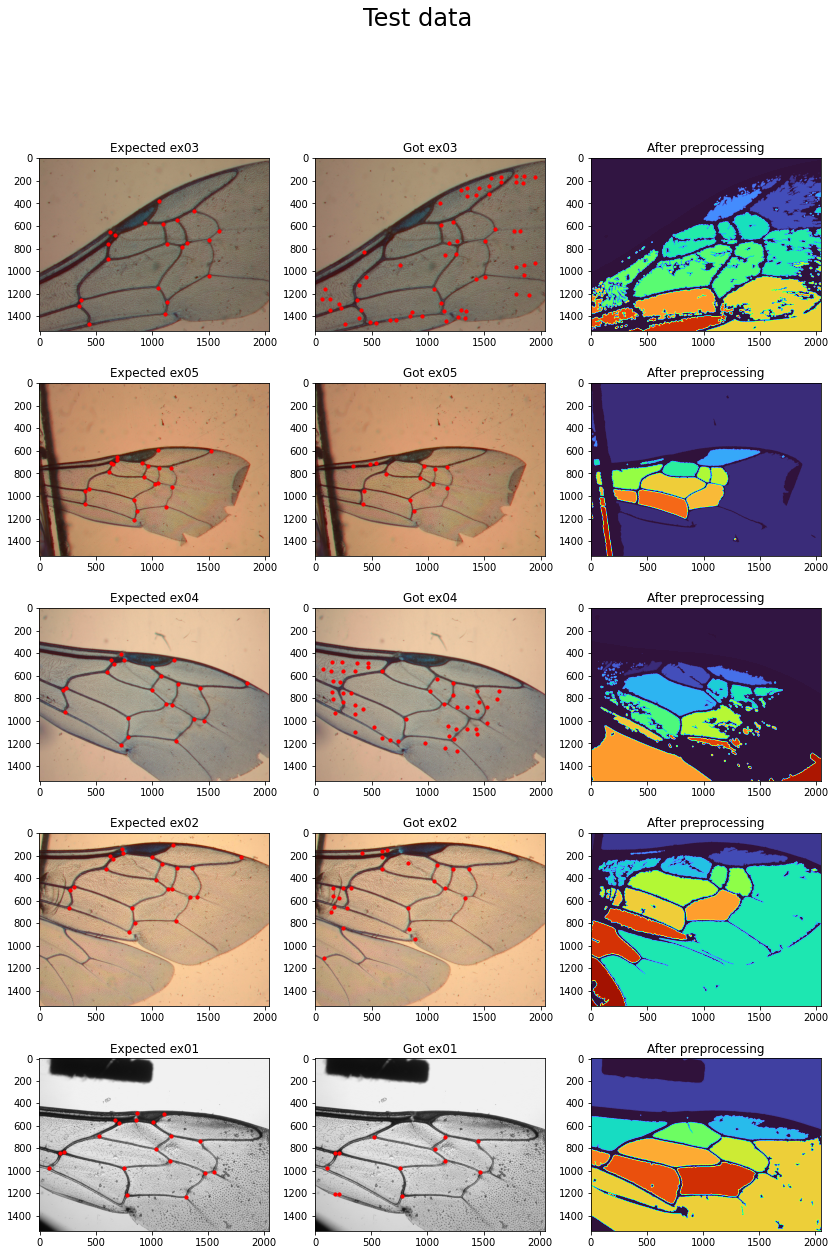

In [44]:
# Display images

plt.figure(figsize=(14, 20))
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    
    plt.subplot(test_nb_images, 3, 3 * i + 1)
    plot_img(test_img_list[i], test_csv_list[i], 'Expected ' + title, scatter=10)
    
    plt.subplot(test_nb_images, 3, 3 * i + 2)
    plot_img(test_img_list[i], test_intersection_list[i], 'Got ' + title, scatter=10)
    
    plt.subplot(test_nb_images, 3, 3 * i + 3)
    plt.imshow(test_preprocessed_img_list[i], cmap='turbo')
    plt.title('After preprocessing')
    
plt.suptitle('Test data', fontsize=24)
plt.show()

## Intersection detection on train data

In [45]:
train_intersection_list = []
window_size = 70

for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    print('Intersection detection on {}'.format(title))
    
    intersection = detect_intersection(train_preprocessed_img_list[i], window_size)
    intersection = merge_intersection_points(train_preprocessed_img_list[i], intersection, 100)
    intersection = merge_intersection_points(train_preprocessed_img_list[i], intersection, 80, start_idx=40)
    
    train_intersection_list.append(intersection)

Intersection detection on 154 Lasioglossum nymphaerum f left 4x
Intersection detection on 1220 Osmia lignaria propinqua f right 4x
Intersection detection on 173 Lasioglossum rohweri f left 4x
Intersection detection on 385 Lasioglossum leucozonium f left 3.2x
Intersection detection on 1062 Agapostemon texanus f right 3.2x
Intersection detection on 84 Lasioglossum MAWIspB f left 4x
Intersection detection on 1165 Agapostemon texanus f left 3.2x
Intersection detection on 87 Lasioglossum pilosum f left 4x
Intersection detection on 1118 Osmia lignaria lignaria f right 4x
Intersection detection on 50 Lasioglossum rohweri f right 4x
Intersection detection on 7 Lasioglossum leucozonium f left 3.2x
Intersection detection on 154 Lasioglossum nymphaerum f right 4x
Intersection detection on 85 Lasioglossum rohweri f right 4x
Intersection detection on 133 Lasioglossum nymphaerum f right 4x
Intersection detection on 133 Lasioglossum nymphaerum f left 4x
Intersection detection on 004 Osmia lignaria f 

In [48]:
train_intersection_list[0]

0     1
0    437   927
1    490   647
2    455  1872
3    595   770
4    560  1242
5    595  1347
6    595  1505
7    665  1155
8    700  1155
9    787   472
10   787  1286
11   770  1330
12   910   245
13   840  1470
14   980   393
15   962   980
16   962  1015
17  1102  1015

In [49]:
csv_ref

0       1
0    589.0  1048.0
1    600.0  1520.0
2    654.0   684.0
3    679.0   692.0
4    705.0   913.0
5    708.0   631.0
6    715.0   653.0
7    736.0   964.0
8    747.0  1163.0
9    747.0  1056.0
10   790.0   618.0
11   834.0   925.0
12   887.0  1054.0
13   891.0  1026.0
14   918.0  1176.0
15   942.0   435.0
16   958.0   405.0
17  1033.0   836.0
18  1071.0   403.0
19  1094.0  1124.0
20  1131.0   866.0
21  1211.0   843.0

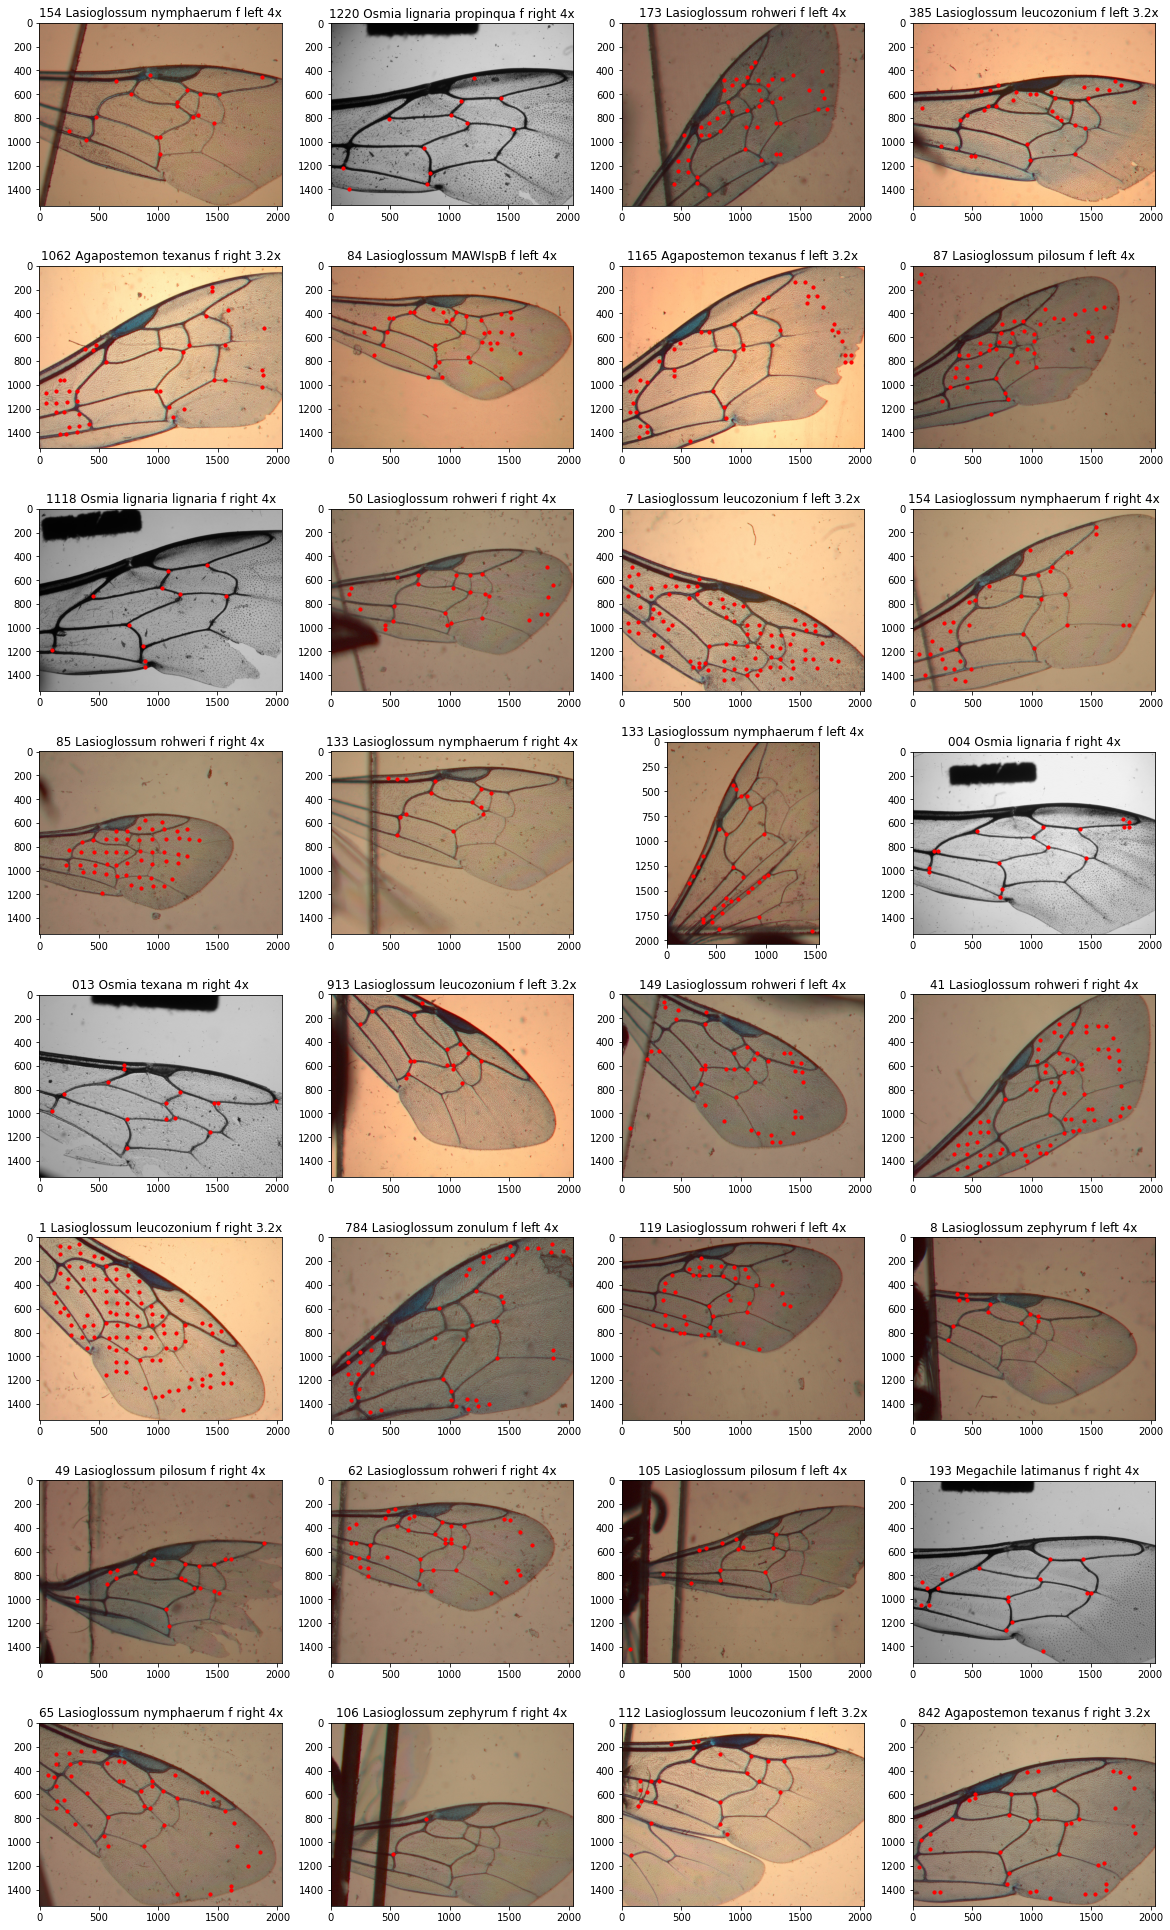

In [46]:
# Display 4 images per line

plt.figure(figsize=(20, 35))
for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    
    plt.subplot(8, 4, i + 1)
    plot_img(train_img_list[i], train_intersection_list[i], scatter=10)
    plt.title(title)
    
plt.show()

# Score

In [2]:
import numpy as np

In [98]:
def is_point_good(p_pred, y_true, error_px):
    '''
    Check if 'pred' is matching with one point of y_true
    '''
    nb_true = len(y_true)
    for idx in range(nb_true):
        p_true = (int(y_true.iloc[idx][0]), int(y_true.iloc[idx][1]))

        if abs(p_true[0] - p_pred[0]) < error_px and abs(p_true[1] - p_pred[1]):
            return True, idx

    return False, -1

def compute_score(y_preds, y_true, error_px):
    '''
    Compute accuracy / precision / recall and f1-score
    
    params:
        'y_preds': dataframe with all the predictions
        'y_true': dataframe with all the labels
    '''
    TP = 0
    nb_preds = len(y_preds)
    y_true_cpy = y_true.copy()
    for idx in range(nb_preds):
        p_pred = (int(y_preds.iloc[idx][0]), int(y_preds.iloc[idx][1]))

        is_good, idx_true = is_point_good(p_pred, y_true_cpy, error_px)
        if is_good:
            TP += 1
            y_true_cpy = y_true_cpy.drop([idx_true])
            y_true_cpy = y_true_cpy.reset_index()
            y_true_cpy = y_true_cpy.drop(columns=['index'])

    # compute precision (<=> accuracy in our case)
    # precision = TP / (TP + FP)
    precision = TP / nb_preds

    # compute recall (recall = TP / (TP + FN))
    recall = TP / len(y_true)

    # compute f1-score (f1-score = 2 * precision * recall / (precision + recall))
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score

In [106]:
def compute_scores_all_imgs(y_preds_list, y_true_list):
    m = len(y_preds_list)
    for i in range(m):
        precision, recall, f1_score = compute_score(y_preds_list[i], y_true_list[i], 30)
        print("Precision: {} / Recall: {} / F1: {}".format(precision, recall, f1_score))

In [107]:
compute_score(test_intersection_list[2], test_csv_list[2], 30)

(0.35294117647058826, 0.782608695652174, 0.48648648648648657)

In [108]:
compute_scores_all_imgs(test_intersection_list, test_csv_list)

Precision: 0.23809523809523808 / Recall: 0.7142857142857143 / F1: 0.35714285714285715
Precision: 1.0 / Recall: 0.6363636363636364 / F1: 0.7777777777777778
Precision: 0.35294117647058826 / Recall: 0.782608695652174 / F1: 0.48648648648648657
Precision: 0.68 / Recall: 0.7391304347826086 / F1: 0.7083333333333334
Precision: 0.9230769230769231 / Recall: 0.631578947368421 / F1: 0.7499999999999999
